### Imports and helper functions

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
from arch import arch_model
import warnings, os
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def _asinh_transform(series):
    med = series.median()
    mad = (series - med).abs().median()*1.4826
    return np.arcsinh((series-med)/mad), med, mad

def _asinh_inverse(s, med, mad):
    return np.sinh(s)*mad + med

In [3]:
def preprocess_energy_data(file_path):
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    df.index.name = 'Timestamp'
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('Europe/Amsterdam')

    # Handle duplicates
    if df.index.duplicated().sum() > 0:
        df = df.sort_index().groupby(level=0).mean()

    # Force hourly frequency and interpolate missing values
    df = df.asfreq('h').interpolate(limit_direction='both')

    # Target variable
    price_series = df['Price'].dropna()

    # Define variables
    base_vars = [
        'Solar', 'Wind Onshore', 'Wind Offshore',
        'Load Forecast (MW)', 'Actual Aggregated', 'Fossil Gas', 'Other', 'Waste'
    ]
    weather_vars = [
        'temperature_2m', 'cloudcover', 'wind_speed_10m',
        'shortwave_radiation', 'sunshine_duration'
    ]
    exog_vars = base_vars + weather_vars
    exog = df[exog_vars].copy()

    # Add time-based features
    df['Hour'] = df.index.hour
    df['IsWeekend'] = (df.index.dayofweek >= 5).astype(float)
    df['Month'] = df.index.month
    month_dummies = pd.get_dummies(df['Month'], prefix='Month', drop_first=True)
    extra_features = pd.concat([df[['Hour', 'IsWeekend']], month_dummies], axis=1).astype(float)

    # Combine and interpolate
    exog_full = pd.concat([exog, extra_features], axis=1).interpolate(limit_direction='both')
    exog_raw = exog_full

    # Scale features
    scaler = StandardScaler()
    exog_scaled = pd.DataFrame(
        scaler.fit_transform(exog_full),
        columns=exog_full.columns,
        index=exog_full.index
    )

    # Align indices
    common_index = price_series.index.intersection(exog_scaled.index)
    price_series = price_series.loc[common_index]
    exog_scaled = exog_scaled.loc[common_index]

    return price_series, exog, exog_raw

file_path = '/Users/larskinkel/Documents/UvA/Master/Thesis/ThesisData/merged_energy_weather_2022_2024.csv'
price, exog, exog_raw = preprocess_energy_data(file_path)

In [4]:
scaler_price = MinMaxScaler()
price_scaled = scaler_price.fit_transform(price.values.reshape(-1, 1))

### Electricity Price Data Visualization

/Users/larskinkel/anaconda3/envs/MLE2024/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/larskinkel/anaconda3/envs/MLE2024/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ADF Test Statistic: -6.137140557205142
p-value: 8.13547481720705e-08
Critical Values: {'1%': -3.430599102593299, '5%': -2.8616500960359854, '10%': -2.5668286008605627}
The series is likely stationary (reject H0).


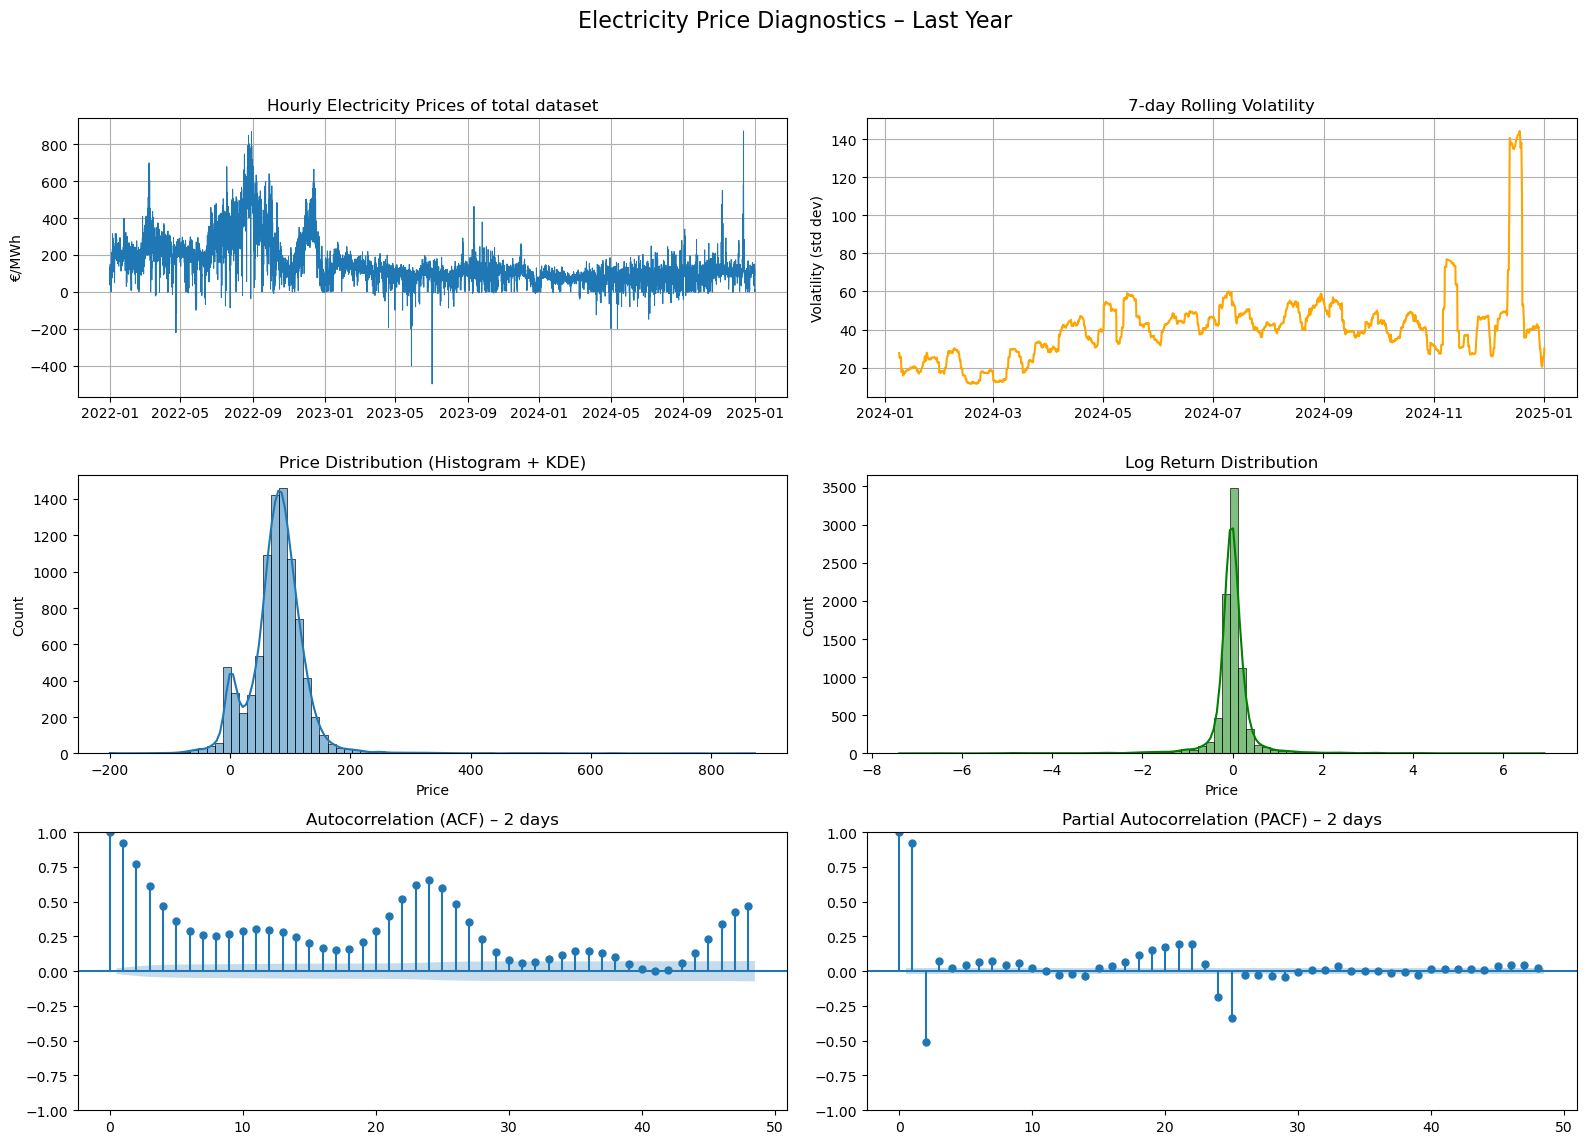

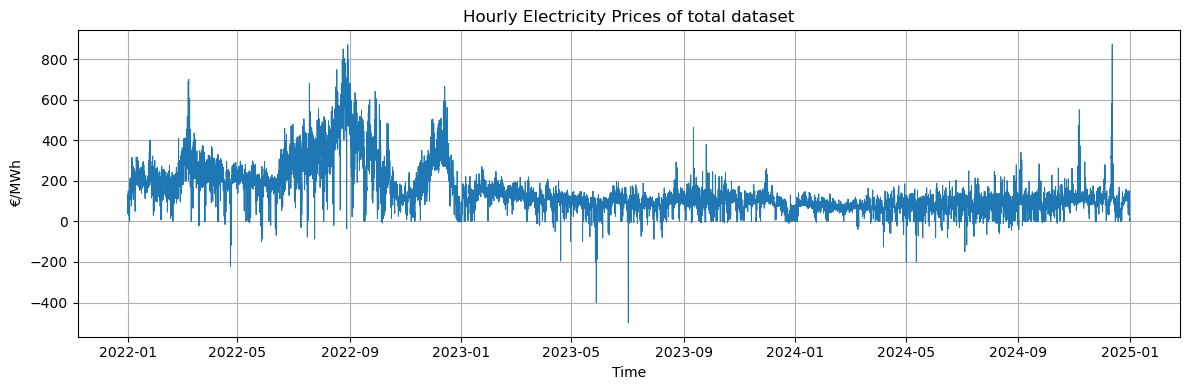

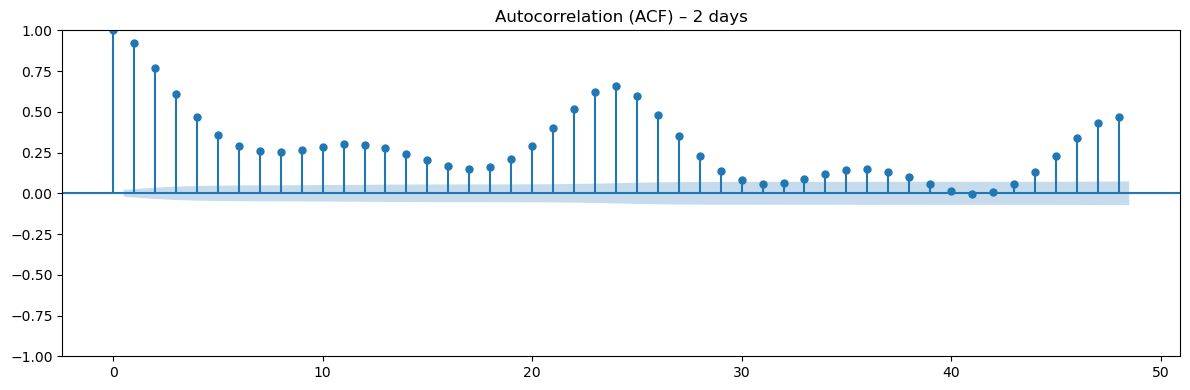

In [5]:
# Filter last year
last_year = price.last('365D')
returns = np.log(last_year / last_year.shift(1)).dropna()
volatility = last_year.rolling(window=24*7).std()  # 7-day hourly rolling

# Run ADF test for stationarity
adf_result = adfuller(price.dropna())
print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])
if adf_result[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

# Plot everything
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Electricity Price Diagnostics – Last Year', fontsize=16)

# 1. Time Series
axes[0, 0].plot(price.index, price, label='Price (€/MWh)', linewidth=0.7)
axes[0, 0].set_title('Hourly Electricity Prices of total dataset')
axes[0, 0].set_ylabel('€/MWh')
axes[0, 0].grid(True)

# 2. Volatility
axes[0, 1].plot(volatility.index, volatility, color='orange', label='7-day rolling std')
axes[0, 1].set_title('7-day Rolling Volatility')
axes[0, 1].set_ylabel('Volatility (std dev)')
axes[0, 1].grid(True)

# 3. Histogram + KDE
sns.histplot(last_year, bins=80, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Price Distribution (Histogram + KDE)')

# 4. Log Returns Distribution
sns.histplot(returns, bins=80, kde=True, ax=axes[1, 1], color='green')
axes[1, 1].set_title('Log Return Distribution')

# 5. ACF
plot_acf(last_year.dropna(), lags=48, ax=axes[2, 0])
axes[2, 0].set_title('Autocorrelation (ACF) – 2 days')

# 6. PACF
plot_pacf(last_year.dropna(), lags=48, ax=axes[2, 1], method='ywm')
axes[2, 1].set_title('Partial Autocorrelation (PACF) – 2 days')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Time Series plot
plt.figure(figsize=(12, 4))
plt.plot(price.index, price, label='Price (€/MWh)', linewidth=0.7)
plt.title('Hourly Electricity Prices of total dataset')
plt.ylabel('€/MWh')
plt.xlabel('Time')
plt.grid(True)
plt.tight_layout()
plt.show()

# Autocorrelation (ACF) plot
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(last_year.dropna(), lags=48, ax=ax)
ax.set_title('Autocorrelation (ACF) – 2 days')
plt.tight_layout()
plt.show()

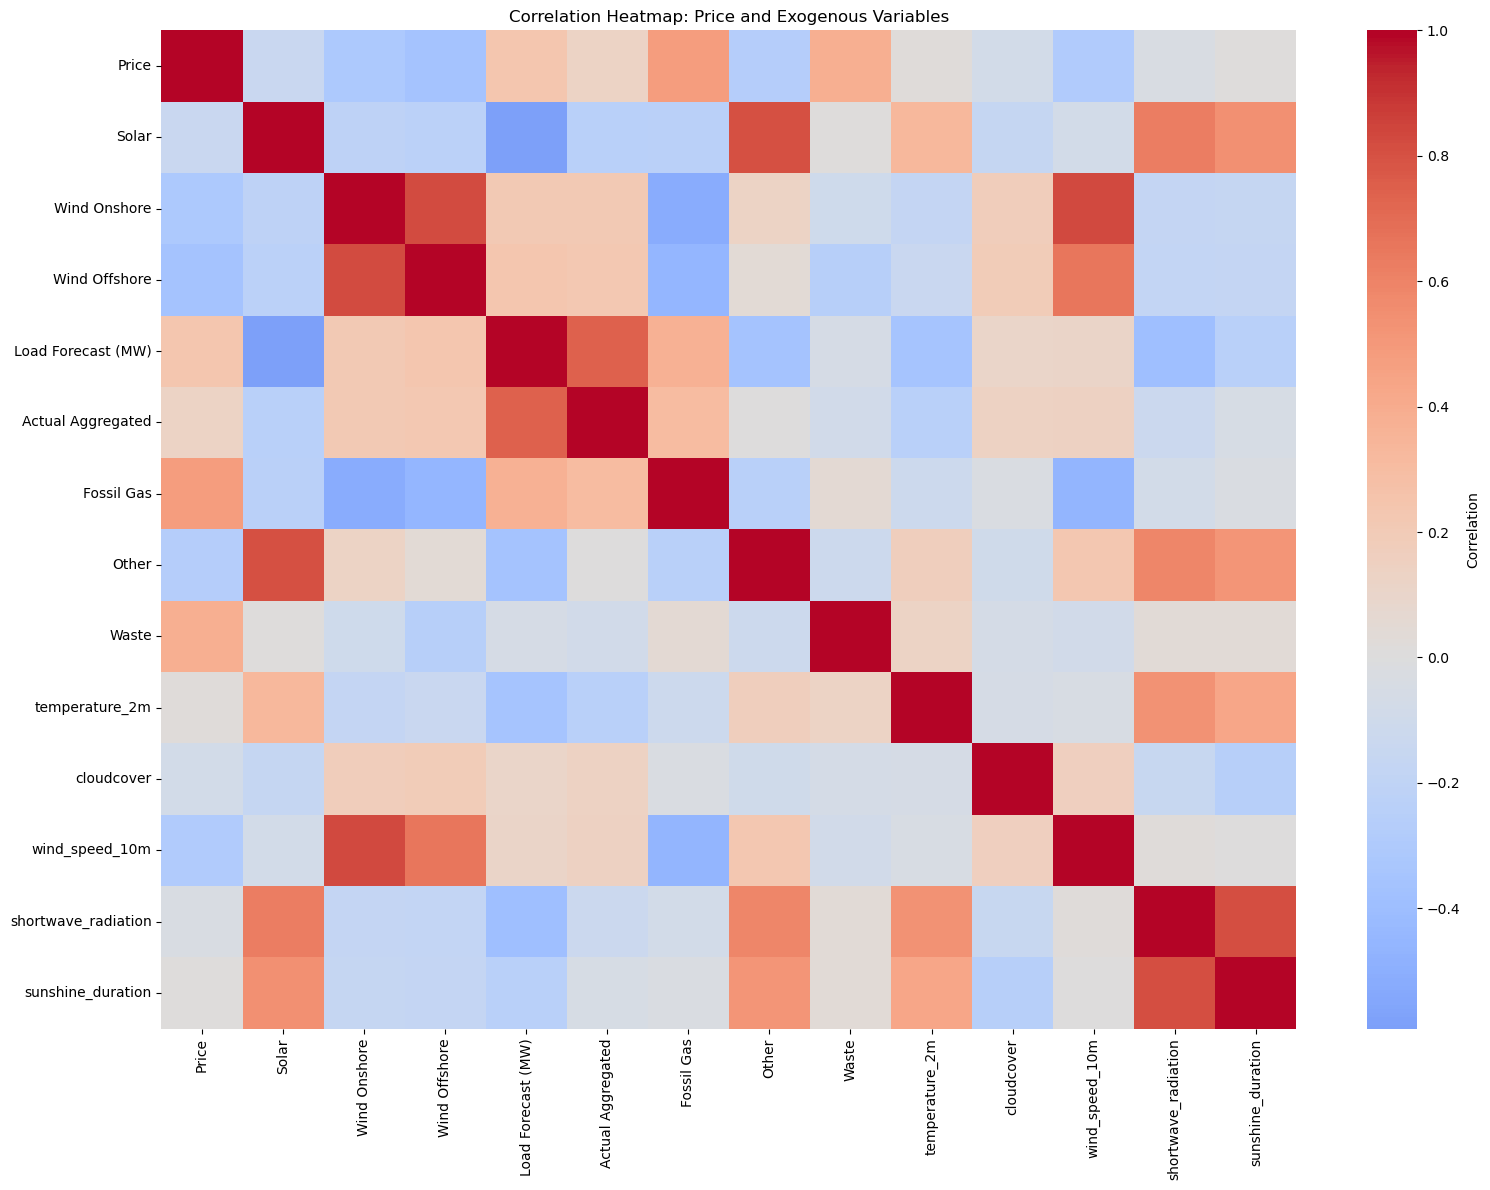

Correlation of each variable with Price:
Price                  1.000000
Fossil Gas             0.479829
Waste                  0.384778
Load Forecast (MW)     0.235831
Actual Aggregated      0.128870
temperature_2m         0.017717
sunshine_duration      0.013173
shortwave_radiation   -0.035356
cloudcover            -0.075977
Solar                 -0.138636
Other                 -0.272758
wind_speed_10m        -0.291772
Wind Onshore          -0.315622
Wind Offshore         -0.361941
Name: Price, dtype: float64


In [6]:
# Combine price and exogenous variables for correlation analysis
corr_df = pd.concat([price, exog], axis=1)
corr_df = corr_df.dropna()  # Ensure no missing values

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    annot=False,
    fmt=".2f",
    cbar_kws={'label': 'Correlation'}
)
plt.title("Correlation Heatmap: Price and Exogenous Variables")
plt.tight_layout()
plt.show()

# Show correlations with price, sorted
print("Correlation of each variable with Price:")
print(corr_matrix['Price'].sort_values(ascending=False))

# Find highly collinear pairs
threshold = 0.95
corrs = corr_matrix.abs()
high_corr = np.where((corrs > threshold) & (corrs < 1.0))
for i, j in zip(*high_corr):
    if i < j:
        print(f"High collinearity: {corr_matrix.index[i]} & {corr_matrix.columns[j]} (corr={corr_matrix.iloc[i,j]:.2f})")

### Model functions
AR, ARX, ARX-GARCH, LEAR

In [9]:
# Baseline AR model
def rolling_forecast_AR(series, horizon=24, days=60, lags=24):
    last = series.index[-1].normalize()
    first = last - pd.Timedelta(days=days-1)
    RMSE, MAE, T = [], [], []
    dates = list(pd.date_range(first, last, freq='D'))
    all_preds = []

    for d in tqdm(dates, desc="AR Forecast"):
        y_train = series.loc[:d-pd.Timedelta(hours=1)]
        y_test  = series.loc[d:d+pd.Timedelta(hours=horizon-1)]
        if len(y_train)<lags or len(y_test)<horizon: continue
        mdl = AutoReg(y_train,lags=lags,old_names=False).fit()
        y_hat = mdl.predict(start=len(y_train), end=len(y_train)+horizon-1)
        y_hat.index = y_test.index
        RMSE.append(np.sqrt(mean_squared_error(y_test, y_hat)))
        MAE.append(mean_absolute_error(y_test, y_hat))
        T.append(d)
        all_preds.append(y_hat)

    preds_full = pd.concat(all_preds).sort_index() if all_preds else pd.Series(dtype=float)

    return RMSE, MAE, T, preds_full

# ARX model extension, including exogenous variables
def rolling_forecast_ARX(series, exog, horizon=24, days=60, lags=24):
    last = series.index[-1].normalize()
    first = last - pd.Timedelta(days=days-1)
    RMSE, MAE, T, all_preds = [], [], [], []
    dates = list(pd.date_range(first, last, freq='D'))

    for d in tqdm(dates, desc="ARX Forecast"):
        y_train = series.loc[:d-pd.Timedelta(hours=1)]
        X_train = exog.loc[:d-pd.Timedelta(hours=1)]
        y_test  = series.loc[d:d+pd.Timedelta(hours=horizon-1)]
        X_test  = exog.loc[d:d+pd.Timedelta(hours=horizon-1)]
        
        if len(y_train)<lags or len(y_test)<horizon: continue
        scl = StandardScaler(); X_tr = scl.fit_transform(X_train); X_te = scl.transform(X_test)
        mdl = AutoReg(y_train,lags=lags,exog=X_tr,old_names=False).fit()
        y_hat = mdl.predict(start=len(y_train), end=len(y_train)+horizon-1, exog_oos=X_te)
        y_hat.index = y_test.index
        RMSE.append(np.sqrt(mean_squared_error(y_test, y_hat)))
        MAE.append(mean_absolute_error(y_test, y_hat))
        T.append(d)
        all_preds.append(y_hat)
    
    preds_full = pd.concat(all_preds).sort_index() if all_preds else pd.Series(dtype=float)

    return RMSE, MAE, T, preds_full

# # ARX-GARCH model 
# def rolling_forecast_ARXGARCH(series, exog, horizon=24, days=60, lags=72):
#     last = series.index[-1].normalize()
#     first = last - pd.Timedelta(days=days-1)
#     RMSE, MAE, T = [], [], []
#     dates = list(pd.date_range(first, last, freq='D'))

#     for d in tqdm(dates, desc="ARX-GARCH Forecast"):
#         y_tr = series.loc[:d-pd.Timedelta(hours=1)]
#         X_tr = exog.loc[:d-pd.Timedelta(hours=1)]
#         y_te = series.loc[d:d+pd.Timedelta(hours=horizon-1)]
#         X_te = exog.loc[d:d+pd.Timedelta(hours=horizon-1)]
#         if len(y_tr)<lags or len(y_te)<horizon or X_tr.isna().any().any(): continue
#         scl = StandardScaler(); Xtr = scl.fit_transform(X_tr); Xte = scl.transform(X_te)
#         mean_mod = AutoReg(y_tr, lags=lags, exog=Xtr, old_names=False).fit()
#         resid = mean_mod.resid
#         garch = arch_model(resid, p=1, q=1, mean='zero').fit(disp='off')
#         y_hat = mean_mod.predict(start=len(y_tr), end=len(y_tr)+horizon-1, exog_oos=Xte)
#         y_hat.index = y_te.index
#         RMSE.append(np.sqrt(mean_squared_error(y_te, y_hat)))
#         MAE.append(mean_absolute_error(y_te, y_hat))
#         T.append(d)
#     return RMSE, MAE, T


def rolling_forecast_LEAR(series, exog, horizon=24, days=60,
                           window_days=56, cv_folds=5,
                           max_pred_threshold=1e3):

    # Apply asinh transform
    y_as, med, mad = _asinh_transform(series)

    # Feature engineering
    feats = pd.DataFrame(index=series.index)
    feats['p_d1']   = y_as.shift(24)
    feats['p_d2']   = y_as.shift(48)
    feats['p_d3']   = y_as.shift(72)
    feats['p_d7']   = y_as.shift(168)

    for col in exog.columns:
        feats[f'{col}_d0'] = exog[col]
        feats[f'{col}_d1'] = exog[col].shift(24)
        feats[f'{col}_d7'] = exog[col].shift(168)
    
    hour = pd.get_dummies(series.index.hour, prefix='hour')
    feats = pd.concat([feats, hour], axis=1)

    dow = pd.get_dummies(series.index.dayofweek, prefix='dow')
    feats = pd.concat([feats, dow], axis=1)
    feats = feats.ffill().bfill()

    last_day  = series.index[-1].normalize()
    first_day = last_day - pd.Timedelta(days=days - 1)

    RMSE, MAE, DATES = [], [], []
    all_preds, all_true = [], []

    for current_day in tqdm(pd.date_range(first_day, last_day, freq='D'), desc="LEAR Forecast"):
        test_idx = pd.date_range(current_day, periods=horizon, freq='H')

        if test_idx[-1] not in feats.index or feats.loc[test_idx].isna().any().any():
            print(f"Skipping {current_day.date()} — missing features in test window")
            continue

        preds = []
        y_true = series.loc[test_idx]

        for h in range(horizon):
            ts_h = test_idx[h]
            tr_end = ts_h - pd.Timedelta(hours=1)
            tr_st  = tr_end - pd.Timedelta(days=window_days - 1)
            train_hours = pd.date_range(tr_st, tr_end, freq='H')
            train_hours = train_hours[train_hours.hour == h]

            X_train = feats.loc[train_hours].dropna()
            if X_train.empty:
                print(f"Skipping {current_day.date()} — no training data at hour {h}")
                break

            y_train = y_as.loc[X_train.index]

            try:
                scaler = StandardScaler()
                Xs = scaler.fit_transform(X_train)
                lasso = LassoCV(cv=TimeSeriesSplit(cv_folds), fit_intercept=True).fit(Xs, y_train)

                X_test = feats.loc[[ts_h]]
                X_hat = scaler.transform(X_test)
                y_hat = lasso.predict(X_hat)[0]
                preds.append(y_hat)
            except Exception as e:
                print(f"Lasso error on {current_day.date()} hour {h}: {e}")
                break

        if len(preds) < horizon:
            print(f"Skipping {current_day.date()} — incomplete prediction (only {len(preds)} hours)")
            continue

        preds = np.array(preds)

        if np.any(np.isnan(preds)) or np.any(np.isinf(preds)) or np.max(np.abs(preds)) > max_pred_threshold:
            print(f"Skipping {current_day.date()} — abnormal prediction values (max={np.max(np.abs(preds)):.2e})")
            continue

        preds = np.clip(preds, -50, 50)

        try:
            y_hat_lvl = _asinh_inverse(pd.Series(preds, index=test_idx), med, mad)
        except Exception as e:
            print(f"Inverse asinh error on {current_day.date()}: {e}")
            continue

        rmse = np.sqrt(mean_squared_error(y_true, y_hat_lvl))
        mae  = mean_absolute_error(y_true, y_hat_lvl)

        if np.isnan(rmse) or rmse > max_pred_threshold:
            print(f"Skipping {current_day.date()} — unstable RMSE = {rmse}")
            continue

        RMSE.append(rmse)
        MAE.append(mae)
        DATES.append(current_day)
        all_preds.append(y_hat_lvl)
        all_true.append(y_true)

    preds_full = pd.concat(all_preds).sort_index() if all_preds else pd.Series(dtype=float)
    true_full  = pd.concat(all_true ).sort_index() if all_true  else pd.Series(dtype=float)

    return RMSE, MAE, DATES, preds_full, true_full


def rolling_forecast_LEAR_with_AR_fallback(series, exog, horizon=24, days=60,
                                           window_days=56, cv_folds=5,
                                           max_pred_threshold=800,
                                           fallback_lags=24):

    y_as, med, mad = _asinh_transform(series)

    feats = pd.DataFrame(index=series.index)
    feats['p_d1'] = y_as.shift(24)
    feats['p_d2'] = y_as.shift(48)
    feats['p_d3'] = y_as.shift(72)
    feats['p_d7'] = y_as.shift(168)

    for col in exog.columns:
        feats[f'{col}_d0'] = exog[col]
        feats[f'{col}_d1'] = exog[col].shift(24)
        feats[f'{col}_d7'] = exog[col].shift(168)

    hour = pd.get_dummies(series.index.hour, prefix='hour')
    dow = pd.get_dummies(series.index.dayofweek, prefix='dow')
    feats = pd.concat([feats, hour, dow], axis=1).ffill().bfill()

    last_day = series.index[-1].normalize()
    first_day = last_day - pd.Timedelta(days=days - 1)

    RMSE, MAE, DATES = [], [], []
    all_preds, all_true = [], []
    LEAR_used, AR_used = 0, 0
    model_used_per_day = {}

    for current_day in tqdm(pd.date_range(first_day, last_day, freq='D'), desc="LEAR + AR Forecast"):
        test_idx = pd.date_range(current_day, periods=horizon, freq='H')
        if test_idx[-1] not in series.index:
            print(f"Skipping {current_day.date()} — forecast horizon exceeds data")
            continue

        y_true = series.loc[test_idx]
        fallback = False

        tr_end = current_day - pd.Timedelta(hours=1)
        tr_st = tr_end - pd.Timedelta(days=window_days)
        train_idx = pd.date_range(tr_st, tr_end, freq='H')
        X_train = feats.loc[train_idx].dropna()

        if X_train.empty:
            fallback = True
        else:
            y_train = y_as.loc[X_train.index]
            try:
                scaler = StandardScaler()
                Xs = scaler.fit_transform(X_train)
                lasso = LassoCV(cv=TimeSeriesSplit(cv_folds), fit_intercept=True).fit(Xs, y_train)

                X_test = feats.loc[test_idx]
                X_hat = scaler.transform(X_test)
                y_hat_trans = lasso.predict(X_hat)
                preds = _asinh_inverse(pd.Series(y_hat_trans, index=test_idx), med, mad)

                if np.any(np.isnan(preds)) or np.any(np.abs(y_hat_trans) > max_pred_threshold):
                    raise ValueError("Invalid LEAR predictions")

                rmse = np.sqrt(mean_squared_error(y_true, preds))
                mae = mean_absolute_error(y_true, preds)

                if np.isnan(rmse) or rmse > 800:
                    raise ValueError("Unstable RMSE")

                LEAR_used += 1
                model_used_per_day[current_day.date()] = 'LEAR'
                y_hat = preds

            except Exception as e:
                print(f"LEAR fallback on {current_day.date()}: {e}")
                fallback = True

        if fallback:
            y_train = series.loc[:current_day - pd.Timedelta(hours=1)]
            if len(y_train) < fallback_lags or len(y_true) < horizon:
                print(f"Skipping {current_day.date()} — insufficient AR data")
                continue
            try:
                ar_model = AutoReg(y_train, lags=fallback_lags, old_names=False).fit()
                y_hat = ar_model.predict(start=len(y_train), end=len(y_train) + horizon - 1)
                y_hat.index = y_true.index
                rmse = np.sqrt(mean_squared_error(y_true, y_hat))
                mae = mean_absolute_error(y_true, y_hat)
                AR_used += 1
                model_used_per_day[current_day.date()] = 'AR'
            except Exception as e:
                print(f"AR error on {current_day.date()}: {e}")
                continue

        RMSE.append(rmse)
        MAE.append(mae)
        DATES.append(current_day)
        all_preds.append(y_hat)
        all_true.append(y_true)

    print(f"LEAR used on {LEAR_used} days, AR fallback used on {AR_used} days.")

    preds_full = pd.concat(all_preds).sort_index() if all_preds else pd.Series(dtype=float)
    true_full = pd.concat(all_true).sort_index() if all_true else pd.Series(dtype=float)

    return RMSE, MAE, DATES, preds_full, true_full, model_used_per_day



### Running models and store outcomes

In [11]:
window = 1040  # days to forecast
AR_rmse , AR_mae, AR_t, AR_pred = rolling_forecast_AR(price, horizon=24, days=window)
ARX_rmse, ARX_mae, ARX_t, ARX_pred = rolling_forecast_ARX(price, exog, horizon=24, days=window)
LEAR_rmse, LEAR_mae, LEAR_t, LEAR_pred, true_prices, model_used_per_day = rolling_forecast_LEAR_with_AR_fallback(price, exog, horizon=24, days=window)

LEAR + AR Forecast: 100%|██████████| 1040/1040 [03:08<00:00,  5.52it/s]

Skipping 2025-01-01 — forecast horizon exceeds data
LEAR used on 1039 days, AR fallback used on 0 days.


In [ ]:
# AR_pred.to_csv("AR_predictions_30_6.csv")
# ARX_pred.to_csv("ARX_predictions_30_6.csv")
# LEAR_pred.to_csv("LEAR_predictions_30_6.csv")

In [8]:
LEAR_pred.index

DatetimeIndex(['2022-02-27 00:00:00+01:00', '2022-02-27 01:00:00+01:00',
               '2022-02-27 02:00:00+01:00', '2022-02-27 03:00:00+01:00',
               '2022-02-27 04:00:00+01:00', '2022-02-27 05:00:00+01:00',
               '2022-02-27 06:00:00+01:00', '2022-02-27 07:00:00+01:00',
               '2022-02-27 08:00:00+01:00', '2022-02-27 09:00:00+01:00',
               ...
               '2024-12-31 14:00:00+01:00', '2024-12-31 15:00:00+01:00',
               '2024-12-31 16:00:00+01:00', '2024-12-31 17:00:00+01:00',
               '2024-12-31 18:00:00+01:00', '2024-12-31 19:00:00+01:00',
               '2024-12-31 20:00:00+01:00', '2024-12-31 21:00:00+01:00',
               '2024-12-31 22:00:00+01:00', '2024-12-31 23:00:00+01:00'],
              dtype='datetime64[ns, Europe/Amsterdam]', length=24936, freq=None)

Dates with abnormally high LEAR RMSE (> 200):
2023-07-02 — RMSE: 215.71
2024-12-12 — RMSE: 264.13


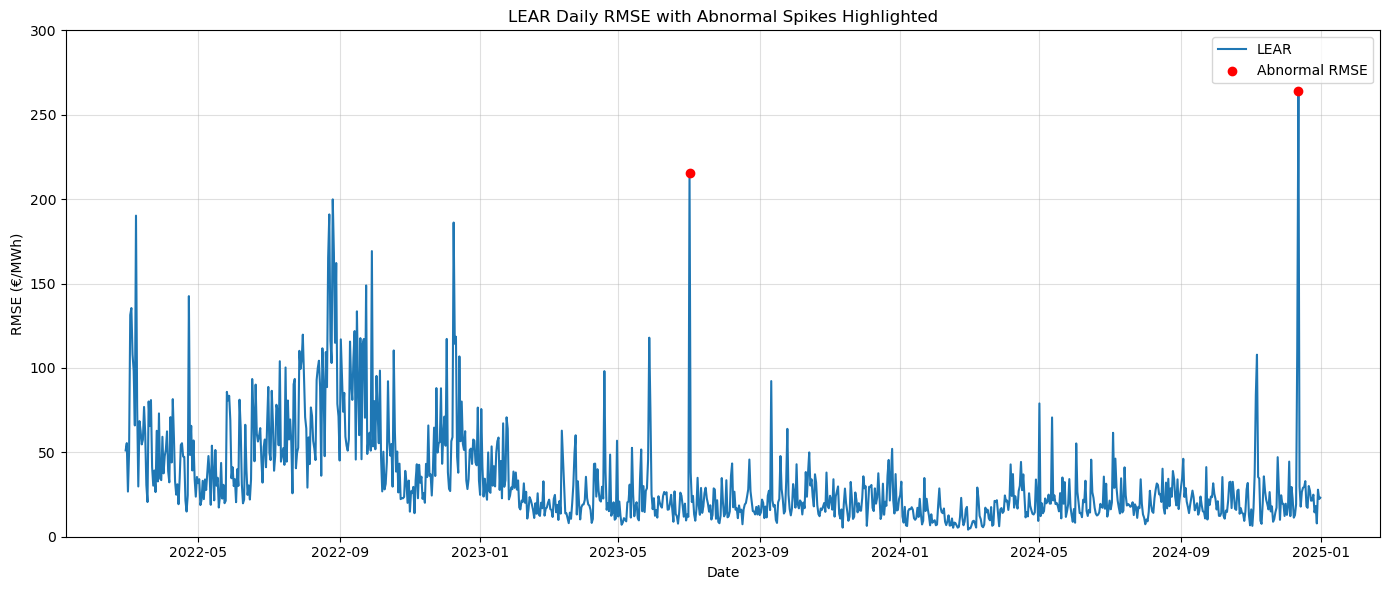

2023-07-02 — AR RMSE: 234.11 €/MWh
2024-12-12 — AR RMSE: 225.74 €/MWh


In [14]:
import matplotlib.dates as mdates

# Set a threshold for "abnormally high" RMSE
threshold = 200  # You can adjust this value

# Find indices where LEAR RMSE exceeds the threshold
abnormal_idx = [i for i, rmse in enumerate(LEAR_rmse) if rmse > threshold]
abnormal_dates = [LEAR_t[i] for i in abnormal_idx]
abnormal_rmse = [LEAR_rmse[i] for i in abnormal_idx]

print("Dates with abnormally high LEAR RMSE (> {}):".format(threshold))
for date, rmse in zip(abnormal_dates, abnormal_rmse):
    print(f"{date.date()} — RMSE: {rmse:.2f}")

# Optional: plot and highlight these points
plt.figure(figsize=(14,6))
plt.plot(LEAR_t, LEAR_rmse, '-', label='LEAR')
plt.scatter(abnormal_dates, abnormal_rmse, color='red', label='Abnormal RMSE', zorder=5)
plt.gca().set_ylim([0, 300])
plt.ylabel('RMSE (€/MWh)')
plt.xlabel('Date')
plt.title('LEAR Daily RMSE with Abnormal Spikes Highlighted')
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
# ...existing code...
for date in abnormal_dates:
    # Find the index of the date in AR_t (if it exists)
    if date in AR_t:
        idx = AR_t.index(date)
        ar_rmse = AR_rmse[idx]
        print(f"{date.date()} — AR RMSE: {ar_rmse:.2f} €/MWh")
    else:
        print(f"{date.date()} — AR RMSE: Not available")

### Performance visualization

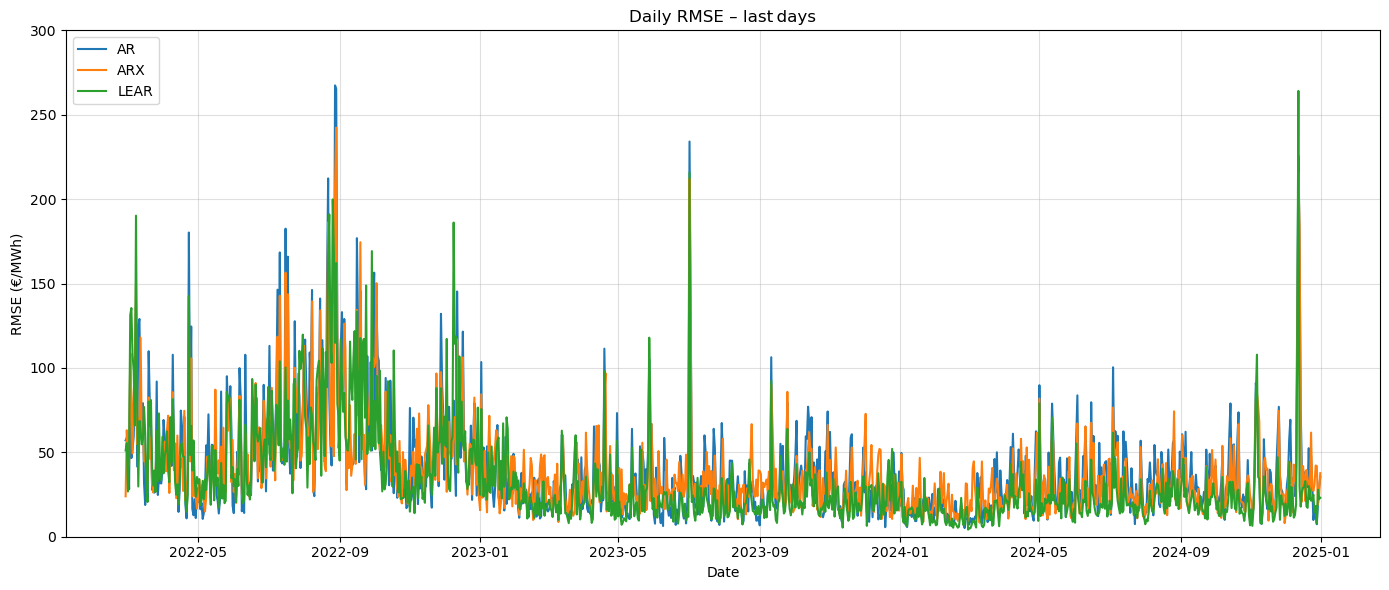


===== Average RMSE and MAE =====
              RMSE               MAE
AR         :  40.00 €/MWh        32.60 €/MWh
ARX        :  38.83 €/MWh        32.01 €/MWh
LEAR       :  33.48 €/MWh        27.51 €/MWh


In [10]:
plt.figure(figsize=(14,6))
plt.plot(AR_t ,AR_rmse ,'-',label='AR')
plt.plot(ARX_t,ARX_rmse,'-',label='ARX')
plt.plot(LEAR_t,LEAR_rmse,'-',label='LEAR')
plt.gca().set_ylim([0, 300])
plt.ylabel('RMSE (€/MWh)'); plt.xlabel('Date')
plt.title('Daily RMSE – last days'); plt.grid(alpha=.4); plt.legend(); plt.tight_layout()
plt.show()

print("\n===== Average RMSE and MAE =====")
print(f"              RMSE               MAE")
print(f"AR         : {np.mean(AR_rmse):6.2f} €/MWh       {np.mean(AR_mae):6.2f} €/MWh")
print(f"ARX        : {np.mean(ARX_rmse):6.2f} €/MWh       {np.mean(ARX_mae):6.2f} €/MWh")
print(f"LEAR       : {np.mean(LEAR_rmse):6.2f} €/MWh       {np.mean(LEAR_mae):6.2f} €/MWh")

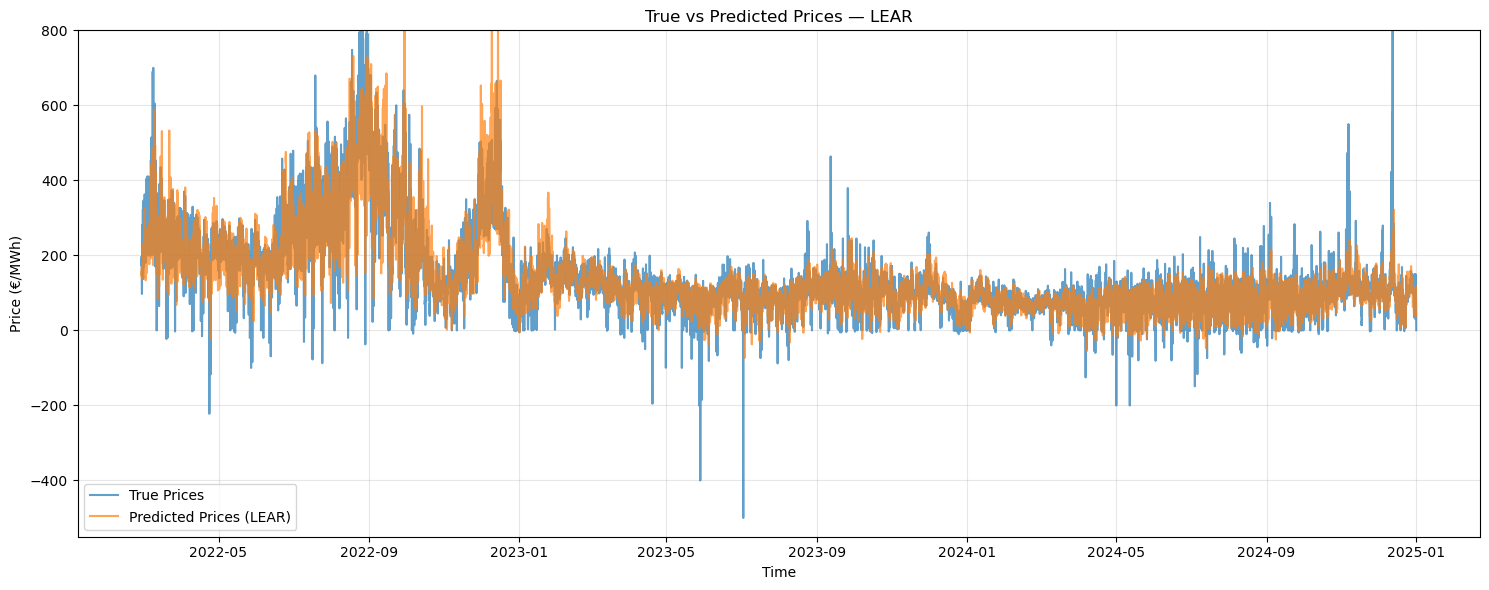

In [11]:
plt.figure(figsize=(15,6))
plt.plot(true_prices.index, true_prices, label="True Prices", alpha=0.7)
plt.plot(LEAR_pred.index, LEAR_pred, label="Predicted Prices (LEAR)", alpha=0.7)
plt.gca().set_ylim([-550, 800])
plt.title("True vs Predicted Prices — LEAR")
plt.xlabel("Time")
plt.ylabel("Price (€/MWh)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## LSTM

In [ ]:

# def create_lstm_dataset(price_series, exog_df, window_size=168, forecast_horizon=24):
#     X, y = [], []
#     for i in range(window_size, len(price_series) - forecast_horizon):
#         past_prices = price_series[i - window_size:i].reshape(-1, 1)
#         exog_block = exog_df[i - window_size:i]
#         X_block = np.hstack([past_prices, exog_block])  # shape (window_size, features)
#         y_block = price_series[i:i + forecast_horizon]
#         X.append(X_block)
#         y.append(y_block)
#     return np.array(X), np.array(y)

# # Scale the data
# scaler_price = MinMaxScaler()
# scaler_exog = MinMaxScaler()

# price_scaled = scaler_price.fit_transform(price.values.reshape(-1, 1))
# exog_scaled = scaler_exog.fit_transform(exog.values)

# # Define the number of daily forecasts (e.g., last 365 days)
# n_forecast_days = 60
# forecast_horizon = 24  # hours per day
# window_size = 168  # hours in the input window

# # Ensure sufficient data points for evaluation
# required_data_points = window_size + n_forecast_days * forecast_horizon
# if len(price_scaled) < required_data_points:
#     raise ValueError(f"Not enough data points in the dataset. Required: {required_data_points}, Found: {len(price_scaled)}")

# # Adjust split point to ensure proper train-test split
# split_point = len(price_scaled) - (n_forecast_days * forecast_horizon + window_size)

# # Training data
# price_train = price_scaled[:split_point]
# exog_train = exog_scaled[:split_point]

# # Evaluation data
# price_eval = price_scaled[split_point:]
# exog_eval = exog_scaled[split_point:]

# # Create training dataset
# X_train, y_train = create_lstm_dataset(price_train, exog_train, window_size=window_size, forecast_horizon=forecast_horizon)

# # Create evaluation dataset
# X_eval, y_true_eval = create_lstm_dataset(price_eval, exog_eval, window_size=window_size, forecast_horizon=forecast_horizon)

# # Build and train the model
# model = Sequential([
#     LSTM(64, input_shape=X_train.shape[1:]),
#     Dense(y_train.shape[1])
# ])
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
# model.fit(X_train, y_train, epochs=10, batch_size=32)


# split_date = '2024-01-01'  # adjust to your last training date
# train_idx = price.index < split_date
# test_idx  = price.index >= split_date

# price_scaled_full = scaler_price.transform(price.values.reshape(-1,1))
# exog_scaled_full = scaler_exog.transform(exog.values)

# # Rebuild time features for full exog
# # time_features_full = add_time_features(price.index)
# # exog_with_time_full = pd.concat([exog, time_features_full], axis=1)

# # Apply scaler to full data
# # exog_scaled_full = scaler_exog.transform(exog_with_time_full)


# window_size     = 168
# forecast_horizon= 24

# X_test = []
# y_test = []
# test_times = []

# split_date = pd.Timestamp('2024-01-01', tz='Europe/Amsterdam')
# start_loc = price.index.get_indexer([pd.to_datetime(split_date)], method='backfill')[0] + window_size
# end_loc   = len(price) - forecast_horizon + 1

# for i in range(start_loc, end_loc, forecast_horizon):
#     past_prices = price_scaled_full[i-window_size:i].reshape(-1,1)
#     past_exog   = exog_scaled_full[i-window_size:i]
#     X_block     = np.hstack([past_prices, past_exog])
#     X_test.append(X_block)
    
#     y_block     = price_scaled_full[i:i+forecast_horizon].reshape(-1)
#     y_test.append(y_block)
    
#     # record the “day” timestamp
#     test_times.append(price.index[i])

# X_test = np.array(X_test)               # shape (n_days, 168, feats)
# y_test = np.array(y_test)               # shape (n_days, 24)

# # 4) Predict all days in one go
# y_pred_scaled = model.predict(X_test, verbose=False)  # shape (n_days, 24)

# # 5) Inverse-scale
# y_pred = scaler_price.inverse_transform(y_pred_scaled)
# y_true = scaler_price.inverse_transform(y_test)

# LSTM_rmse = [
#     mean_squared_error(y_true[i], y_pred[i], squared=False)
#     for i in range(len(y_true))
# ]
# LSTM_mae = [
#     mean_absolute_error(y_true[i], y_pred[i])
#     for i in range(len(y_true))
# ]

In [20]:
print("Available exogenous variables:")
print(list(exog.columns))

forecast_features = [
    'Load Forecast (MW)',      
    'sunshine_duration',                   
]

exog_forecasts = exog[forecast_features].copy()
exog_lstm = exog[['Load Forecast (MW)', 'Fossil Gas', 'Waste', 'Wind Onshore', 'Wind Offshore']].copy()

Available exogenous variables:
['Solar', 'Wind Onshore', 'Wind Offshore', 'Load Forecast (MW)', 'Actual Aggregated', 'Fossil Gas', 'Other', 'Waste', 'temperature_2m', 'cloudcover', 'wind_speed_10m', 'shortwave_radiation', 'sunshine_duration']


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf, numpy as np, random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

def create_time_features(index):
    df = pd.DataFrame(index=index)
    df['hour'] = index.hour
    df['dayofweek'] = index.dayofweek
    hour_dummies = pd.get_dummies(df['hour'], prefix='hour')
    dow_dummies = pd.get_dummies(df['dayofweek'], prefix='dow')
    return pd.concat([hour_dummies, dow_dummies], axis=1)

def lstm_daily_weekly_retrain(price_series, exog, n_days=30, window_size=24, forecast_horizon=24, retrain_every=1):
    """
    LSTM rolling forecast with weekly retraining, RAM-efficient.
    """
    from keras.models import Sequential
    from keras.layers import LSTM, Dense
    from keras.callbacks import EarlyStopping
    from sklearn.preprocessing import MinMaxScaler
    import numpy as np
    from tqdm import tqdm

    scaler_price = MinMaxScaler()
    scaler_exog = MinMaxScaler()
    price_scaled = scaler_price.fit_transform(price_series.values.reshape(-1, 1)).flatten()
    exog_scaled = scaler_exog.fit_transform(exog.values)
    time_features = create_time_features(price_series.index)

    all_y = []
    all_preds = []
    all_dates = []

    start = len(price_series) - n_days * forecast_horizon
    model = None

    for d, i in enumerate(tqdm(range(start, len(price_series) - forecast_horizon, forecast_horizon), desc="LSTM Training")):
        if i - window_size < 0:
            continue

        # Retrain only every 'retrain_every' days
        if d % retrain_every == 0 or model is None:
            X_train_seq = []
            y_train_seq = []
            # Use up to 400 days of history for training
            for j in range(i - 180 * forecast_horizon, i, forecast_horizon):
                if j - window_size < 0:
                    continue
                # --- Only create the single window ending at j ---
                past_prices = price_scaled[j - window_size:j].reshape(-1, 1)
                time_block = time_features.iloc[j - window_size:j].values
                exog_block = exog_scaled[j - window_size:j]
                X_block = np.hstack([past_prices, time_block, exog_block])
                y_block = price_scaled[j:j + forecast_horizon]
                X_train_seq.append(X_block)
                y_train_seq.append(y_block)
            X_train = np.array(X_train_seq)
            y_train = np.array(y_train_seq)
            n_features = X_train.shape[2]

            earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            model = Sequential([
                LSTM(64, input_shape=(window_size, n_features)),
                Dense(forecast_horizon)
            ])
            model.compile(optimizer='adam', loss='mse')
            model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0, callbacks=[earlystop])

        past_prices = price_scaled[i - window_size:i].reshape(-1, 1)
        time_block = time_features.iloc[i - window_size:i].values
        exog_block = exog_scaled[i - window_size:i]
        X_test = np.hstack([past_prices, time_block, exog_block])[np.newaxis, :, :]
        y_true = price_scaled[i:i + forecast_horizon]

        y_pred_scaled = model.predict(X_test, verbose=0).flatten()
        y_pred = scaler_price.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        y_true = scaler_price.inverse_transform(y_true.reshape(-1, 1)).flatten()

        all_preds.append(y_pred)
        all_y.append(y_true)
        all_dates.append(price_series.index[i])

    return np.array(all_y), np.array(all_preds), all_dates

y_true, y_pred, LSTM_t = lstm_daily_weekly_retrain(price, exog_lstm, n_days=366)  # e.g., predict last 60 days

LSTM_rmse = [mean_squared_error(y_true[i], y_pred[i], squared=False) for i in range(len(y_true))]
LSTM_mae = [mean_absolute_error(y_true[i], y_pred[i]) for i in range(len(y_true))]


LSTM Training: 100%|██████████| 365/365 [44:45<00:00,  7.36s/it] 


In [ ]:
pd.DataFrame(
    y_pred, 
    index=pd.to_datetime(LSTM_t), 
    columns=[f'pred_h{h}' for h in range(y_pred.shape[1])]
).to_csv('lstm_predictions_exog.csv', index=True)


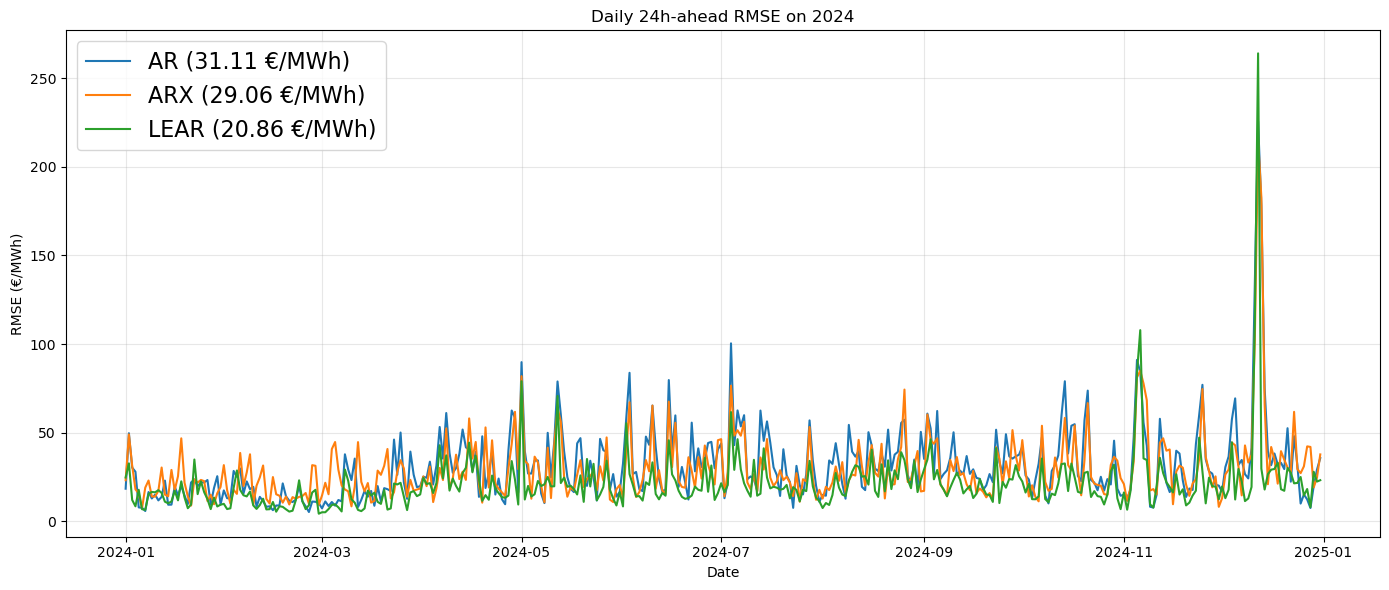

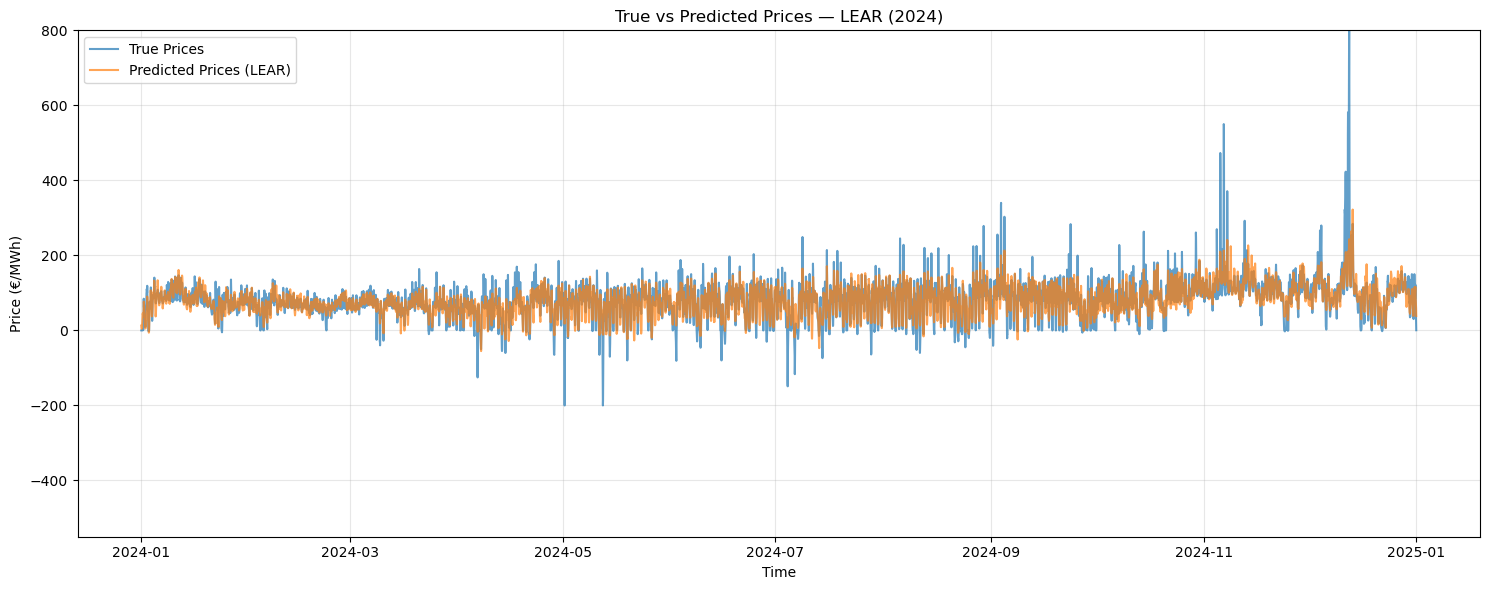

In [13]:
# Convert date lists to pandas Series for easy filtering
LEAR_rmse_2024 = pd.Series(LEAR_rmse, index=pd.to_datetime(LEAR_t))
AR_rmse_2024   = pd.Series(AR_rmse, index=pd.to_datetime(AR_t))
ARX_rmse_2024  = pd.Series(ARX_rmse, index=pd.to_datetime(ARX_t))

LEAR_mae_2024 = pd.Series(LEAR_mae, index=pd.to_datetime(LEAR_t))
AR_mae_2024   = pd.Series(AR_mae, index=pd.to_datetime(AR_t))
ARX_mae_2024  = pd.Series(ARX_mae, index=pd.to_datetime(ARX_t))

# Filter for 2024
start, end = "2024-01-01", "2024-12-31"
LEAR_rmse_2024 = LEAR_rmse_2024[start:end]
AR_rmse_2024   = AR_rmse_2024[start:end]
ARX_rmse_2024  = ARX_rmse_2024[start:end]

LEAR_mae_2024 = LEAR_mae_2024[start:end]
AR_mae_2024   = AR_mae_2024[start:end]
ARX_mae_2024  = ARX_mae_2024[start:end]

# print("===== 2024 RMSE and MAE =====")
# print(f"              RMSE               MAE")
# print(f"AR   : {AR_rmse_2024.mean():6.2f} €/MWh   {AR_mae_2024.mean():6.2f} €/MWh")
# print(f"ARX  : {ARX_rmse_2024.mean():6.2f} €/MWh   {ARX_mae_2024.mean():6.2f} €/MWh")
# print(f"LEAR : {LEAR_rmse_2024.mean():6.2f} €/MWh   {LEAR_mae_2024.mean():6.2f} €/MWh")

plt.figure(figsize=(14,6))
plt.plot(AR_rmse_2024.index, AR_rmse_2024, '-', label=f'AR ({AR_rmse_2024.mean():.2f} €/MWh)')
plt.plot(ARX_rmse_2024.index, ARX_rmse_2024, '-', label=f'ARX ({ARX_rmse_2024.mean():.2f} €/MWh)')
plt.plot(LEAR_rmse_2024.index, LEAR_rmse_2024, '-', label=f'LEAR ({LEAR_rmse_2024.mean():.2f} €/MWh)')
plt.ylabel('RMSE (€/MWh)')
plt.xlabel('Date')
plt.title('Daily 24h-ahead RMSE on 2024')
plt.grid(alpha=0.3)
plt.legend(fontsize=16, loc='upper left')
plt.tight_layout()
plt.show()

true_2024 = true_prices["2024"]
pred_2024 = LEAR_pred["2024"]

plt.figure(figsize=(15,6))
plt.plot(true_2024.index, true_2024, label="True Prices", alpha=0.7)
plt.plot(pred_2024.index, pred_2024, label="Predicted Prices (LEAR)", alpha=0.7)
plt.gca().set_ylim([-550, 800])
plt.title("True vs Predicted Prices — LEAR (2024)")
plt.xlabel("Time")
plt.ylabel("Price (€/MWh)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Results

In [ ]:
print("🔍 Avg RMSE and MAE (2024 forecast)")
print(f"AR        : {np.mean(AR_rmse):6.2f} RMSE   {np.mean(AR_mae):6.2f} MAE")
print(f"ARX       : {np.mean(ARX_rmse):6.2f} RMSE   {np.mean(ARX_mae):6.2f} MAE")
print(f"LEAR      : {np.mean(LEAR_rmse):6.2f} RMSE   {np.mean(LEAR_mae):6.2f} MAE")
print(f"LSTM      : {np.mean(LSTM_rmse):6.2f} RMSE   {np.mean(LSTM_mae):6.2f} MAE")



🔍 Avg RMSE and MAE (2024 forecast)
AR        :  40.00 RMSE    32.60 MAE
ARX       :  38.83 RMSE    32.01 MAE
LEAR      :  33.48 RMSE    27.51 MAE
LSTM      :  31.53 RMSE    25.42 MAE
